In [1]:
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle
import sys
from json import loads

import matplotlib

from contextual_bandit import ContextualBandit
from cascade_bandit import CascadeBandit
from damerau_levenshtien import damerau_levenshtein_distance

sys.path.append("../utils")
from pool_iterator import pool_iterator
from metric import calculate_metric
from json_tools import get_from_pool

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
n_objects = 569105

In [3]:
queries_counter = pickle.load(open("queries_counter", "rb"))
queries_by_word = pickle.load(open("queries_by_word", "rb"))

In [4]:
len(queries_counter)

459862

In [5]:
def parse_query(string):
    return tuple(map(int, string[1:-1].split(", ")))

In [6]:
%%time
nearest_queries = {}
with open("nearest_queries.txt") as handler:
    for i, line in enumerate(handler):
        parsed_line = loads(("{" + line.strip() + "}").replace('(', '"(').replace(')', ')"'))
        query_str = line[:line.find(":")]
        nearest_queries[parse_query(query_str)] = [
            parse_query(other_query)
            for other_query in parsed_line[query_str]
        ]

CPU times: user 4.82 s, sys: 89.1 ms, total: 4.91 s
Wall time: 5.24 s


In [7]:
%%time
position_variants = list(range(10)) + [100]
bandits_by_queries = {
    query: ContextualBandit(position_variants) for query in queries_counter
}
big_bandit = CascadeBandit(bandits_by_queries, nearest_queries)

CPU times: user 38.2 s, sys: 579 ms, total: 38.8 s
Wall time: 38.8 s


In [8]:
pool_filenames = [
    "../../../data/pool_with_queries/train_test_split/day_{}.json".format(i)
    for i in range(4)
]
train_pool_filenames = pool_filenames[:3]
test_pool = pool_filenames[3]

In [9]:
%%time
for pool_filename in train_pool_filenames:
    print(" fitting filename \"{}\"".format(pool_filename))
    for i, item in enumerate(pool_iterator(pool_filename)):
        if i % 10000 == 0:
            print(" {} %".format(round(400 * i / n_objects)))
        query = tuple(map(int, item["query"].split()))
        factors = item["factors"]
        reward = 1 if item["target"] > 0 else 0
        big_bandit.take_reward(query, item["pos"], reward, factors)

 fitting filename "../../../data/pool_with_queries/train_test_split/day_0.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
 fitting filename "../../../data/pool_with_queries/train_test_split/day_1.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
 fitting filename "../../../data/pool_with_queries/train_test_split/day_2.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
CPU times: user 6.89 s, sys: 232 ms, total: 7.12 s
Wall time: 7.63 s


In [10]:
%%time
targets_test = get_from_pool(pool_iterator(test_pool), "target", int)
probas_test = get_from_pool(pool_iterator(test_pool), "p", float)
positions_test = get_from_pool(pool_iterator(test_pool), "pos", int)

CPU times: user 3.87 s, sys: 79.6 ms, total: 3.95 s
Wall time: 4.14 s


In [90]:
thresholds = list(range(10, 100, 10)) + list(range(100, 300, 50))
answer_positions = pickle.load(open("non_contextial_bandits_answer_positions", "rb"))

In [12]:
%%time
statistics = []
for i, item in enumerate(pool_iterator(test_pool)):
    if i % 50000 == 0:
        print(" {} %".format(round(i * 100 / len(positions_test))))
    query = tuple(map(int, item["query"].split()))
    statistics.append(big_bandit.get_statistic_size(query))

 0 %
 35 %
 70 %
CPU times: user 1.87 s, sys: 19.9 ms, total: 1.89 s
Wall time: 1.86 s


In [108]:
statistics = np.array(statistics)
for threshold in thresholds:
    answer_positions[threshold] = np.array(answer_positions[threshold])

Text(0,0.5,'Queries number')

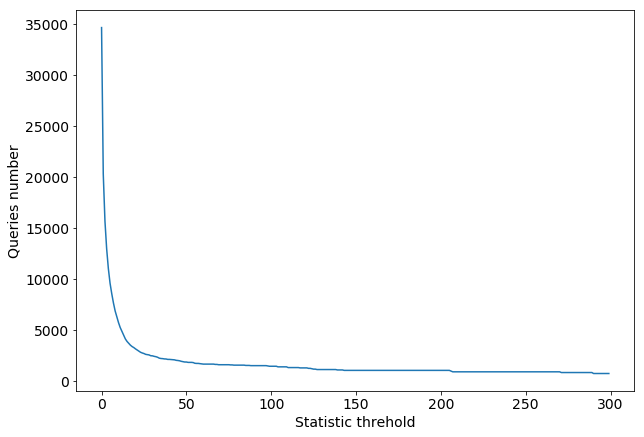

In [14]:
font = {'size'   : 14}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10, 7))

axis = plt.gca()
x = np.arange(max(statistics))
y = np.array([
    len(statistics[statistics > threshold])
    for threshold in x
])
plt.plot(x[:300], y[:300])

axis.set_xlabel("Statistic threhold")
axis.set_ylabel("Queries number")

In [86]:
def compute_metric(threshold, answer):
    mask = (positions_test == answer) * (statistics > threshold)
    return np.sum(targets_test[mask] / probas_test[mask]) / np.sum(1 / probas_test[mask])

In [87]:
def compute_all_metric(threshold, answer):
    tmp_answer = np.copy(answer)
    tmp_answer[statistics < threshold] = 8
    return calculate_metric(
        tmp_answer,
        positions_test,
        targets_test,
        probas_test
    )

In [17]:
def plot_threshold(threshold, head, answer_positions):
    print(' threshold:', threshold)
    answer = answer_positions[threshold]

    axis = plt.gca()
    axis.set_title("Bandits metric")
    x = np.arange(max(statistics))
    y = np.array([
        compute_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[:head], y[:head])
    plt.show()

    axis = plt.gca()
    axis.set_title("All metric")
    y = np.array([
        compute_all_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[:head], y[:head])
    axis.set_ylim(0.62, 0.63)
    plt.show()

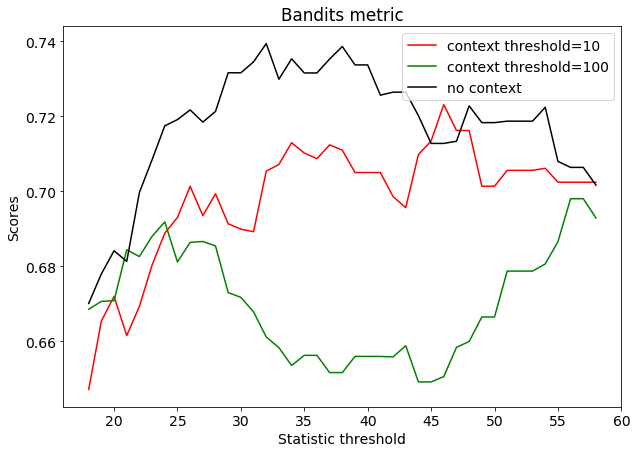

In [115]:
head = 59
start = 18

font = {'size'   : 14}
matplotlib.rc('font', **font)
plt.figure(figsize=(10, 7))
axis = plt.gca()
axis.set_title("Bandits metric")
for threshold, color in zip([10, 100], ['r', 'g', 'b', 'y']):
    answer = answer_positions[threshold]
    answer[statistics < threshold] = 8
    x = np.arange(max(statistics))
    y = np.array([
        compute_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[start:head], y[start:head], color=color, label="context threshold=" + str(threshold))

plt.plot(
    x[start:head],
    np.load("non_context_bandits_metrics.npy")[start:head],
    color='black', label="no context"
)
    
axis.set_xlabel('Statistic threshold')
axis.set_ylabel('Scores')
plt.legend()
plt.show()

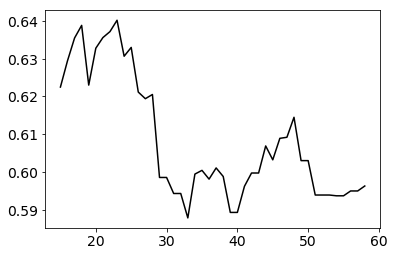

In [111]:
plt.plot(
    x[15:head],
    np.load("non_context_bandits_metrics.npy")[15:head],
    color='black', label="no context"
)

In [54]:
good_predictions = np.load("../data_analysis/substructed_target_predictions/3/train_2_test_3.npy")
good_predictions = np.argmax(good_predictions, axis=1)
print(calculate_metric(
    good_predictions,
    positions_test,
    targets_test,
    probas_test
))

0.6230997560529767


In [59]:
max(np.load("non_context_bandits_sum_metrics.npy")[15:head])

0.6242532818071723

In [62]:
np.load("non_context_bandits_sum_metrics.npy")[15:head][25]

0.6240769832257577

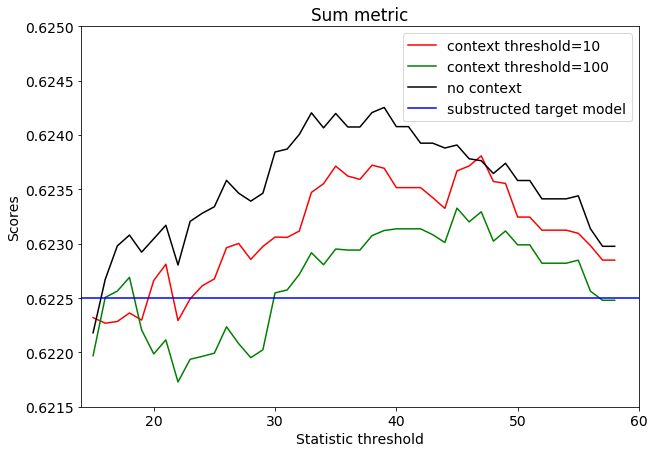

In [106]:
head = 59
plt.figure(figsize=(10, 7))
axis = plt.gca()
axis.set_title("Sum metric")
x = np.arange(max(statistics))
for threshold, color in zip([10, 100], ['r', 'g']):
    answer = answer_positions[threshold]
    #answer[statistics < threshold] = good_predictions[statistics < threshold]
    y = np.array([
        compute_all_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[15:head], y[15:head], color=color, label="context threshold=" + str(threshold))
    
plt.plot(
    x[15:head],
    np.load("non_context_bandits_sum_metrics.npy")[15:head],
    color='black', label="no context"
)
plt.plot(
    [10, head + 1], [0.6225] * 2, color='b', label="substructed target model"
)
axis.set_ylim(0.6215, 0.625)
axis.set_xlim(15-1, head + 1)
axis.set_xlabel('Statistic threshold')
axis.set_ylabel('Scores')
plt.legend()
plt.show()

In [96]:
100 * len(statistics[statistics > 10]) / len(statistics)

4.018246225645927

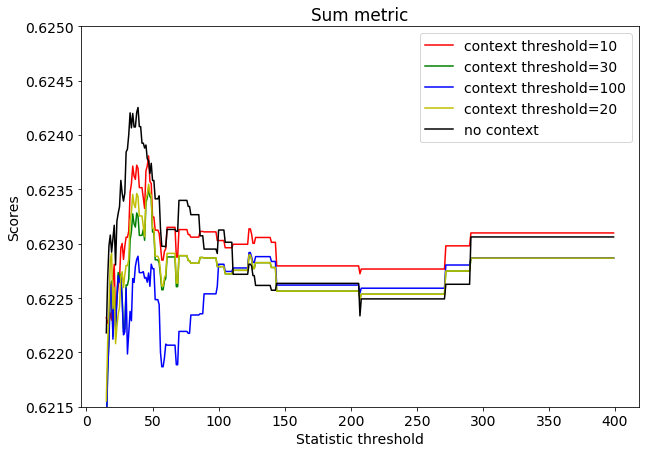

In [33]:
head = 400
plt.figure(figsize=(10, 7))
axis = plt.gca()
axis.set_title("Sum metric")
x = np.arange(max(statistics))
for threshold, color in zip([10, 30, 100, 20], ['r', 'g', 'b', 'y']):
    answer = answer_positions[threshold]
    y = np.array([
        compute_all_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[15:head], y[15:head], color=color, label="context threshold=" + str(threshold))
    
plt.plot(
    x[15:head],
    np.load("non_context_bandits_sum_metrics.npy")[15:head],
    color='black', label="no context"
)

axis.set_ylim(0.6215, 0.625)
axis.set_xlabel('Statistic threshold')
axis.set_ylabel('Scores')
plt.legend()
plt.show()

In [34]:
for i in list(range(10)) + [100]:
    print(' ', i, calculate_metric(
        [i] * len(probas_test),
        positions_test,
        targets_test,
        probas_test
    ))

  0 0.597785108388313
  1 0.6099456748850818
  2 0.612070331062886
  3 0.6208130328867236
  4 0.6088980858768753
  5 0.6147480419683761
  6 0.6207842854047808
  7 0.6103868347937592
  8 0.6226212619831162
  9 0.6197430316646771
  100 0.5989450003878676


In [116]:
len("""В работе исследуется задача разнообразия поисковой выдачи путем добавления на страницу результатов интерактивных элементов, называемых колдунщиками. В качестве методов решения этой задачи используются различные подходы машинного обучения. Для измерения качества введена и зафиксирована численная метрика. В ходе работы проанализированы научные статьи на связные темы. Почерпнутые оттуда идеи и собственные наработки позволили создать гибридный алгоритм, позволяющий значительно улучшить качество решения задачи.""")

511